In [195]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import math
from scipy.signal import kaiserord, lfilter, firwin, freqz, medfilt
import numpy as np
import scipy.signal as signal


In [217]:
# Import der CSV Daten
dfx = pd.read_csv("./run/ID_001_Run  02_Complete_Run.csv", sep=",", decimal=".", encoding='ansi')
dfx = dfx.rename(columns=str.lower)
dfx.columns = dfx.columns.str.replace(' ','_')

for index, row in dfx.iterrows():
    if row["_lightbeam"].strip() == "B11":
        startspeed = row['_speed_km/h']
        break
    else:
        dfx.drop(index=index,inplace=True)
        #print(index)

counter =0
for index, row in dfx.iterrows():
    if row["_lightbeam"].strip() == "2":
        counter=1
        stopspeed = row['_speed_km/h']
        continue
    if counter ==1:
        dfx.drop(index=index,inplace=True)
    
# Geschwindigkeitsdifferenz
deltaspeed = stopspeed-startspeed

# In die Tabelle importieren
dfx['startspeed'] = startspeed
dfx['stopspeed'] = stopspeed
dfx['deltaspeed'] = deltaspeed

# Umschichten in neues Dataframe für weitere Umwandlungen
df = dfx

# Tilt Angle berechnen -(math.degrees(math.atan(12/100)))
df["tilt_value"] = -(np.degrees(np.arctan(df["_acc_y_m/s2"]/df["_acc_x_m/s2"])))

# First, design the Buterworth filter
N  = 3    # Filter order
Wn = 0.01 # Cutoff frequency Hz (1/500)
B, A = signal.butter(N, Wn, output='ba', btype='lowpass')
df['acc_x_smooth'] = signal.filtfilt(B,A, df["_acc_x_m/s2"])
df['acc_y_smooth'] = signal.filtfilt(B,A, df["_acc_y_m/s2"])
df['acc_z_smooth'] = signal.filtfilt(B,A, df["_acc_z_m/s2"])
# Aus den gesmoothten Werten wird der 2D Tit Angle berechnet
df['tilt_smooth_2d'] = -(np.degrees(np.arctan((df['acc_y_smooth'])/(df['acc_x_smooth']))))
# Aus den gesmoothten Werten wird der 3D Tit Angle berechnet
df['tilt_smooth_3d'] = (np.degrees(np.arccos((df['acc_z_smooth'])/np.sqrt(df['acc_x_smooth']**2+df['acc_y_smooth']**2+df['acc_z_smooth']**2 ))))
# https://www.analog.com/en/app-notes/an-1057.html

## Jetzt noch den optimalen Rollwinkel
## https://www.rathaus-winterberg.de/wohnen-leben/bau-planen/bebauungsplaene/
## https://geoservice.maps.arcgis.com/apps/View/index.html?appid=9565f4b2c14544b4a92b04a67958c79c

# Wir lassen die 0 Werte auf n.a.
# df.loc[df["_roll_angle_°"] <=10, 'radius'] =0  
df.loc[(df["_roll_angle_°"] <= (-30) ) & (df["time_s"] >=1 ), 'radius'] = 38.5 
df.loc[(df["_roll_angle_°"] > 50 ) & (df["time_s"] >=8 ), 'radius'] = 20.5 

# Definieren von Speed und Radius
velocity = df["_speed_km/h"]/3.6
radius = df['radius']

df.loc[df["radius"] == 0, 'opt_calc_angle'] = 0

df.loc[df["radius"] == 20.5, 'opt_calc_angle'] = np.degrees(np.arctan((velocity ** 2)/(9.81*radius)))
df.loc[df["radius"] == 38.5, 'opt_calc_angle'] = -(np.degrees(np.arctan((velocity ** 2)/(9.81*radius))))
#df["opt_rangle"] = (np.degrees(np.arctan((velocity ** 2)/(9.81*radius))))

df= df.reset_index(drop=True)
curve_count = (df.time_s).count()
curve_size = 180 # Grad der Kurve

for index, row in df.iterrows():
    df.at[index, 'curve_angle'] =  (index*(180/curve_count))
df.head()
# Daten in CSV sichern...
#pd.DataFrame(df).to_csv("c:/dev/test_v5_1.csv",sep=";")

,time_s,_distance_m,_speed_km/h,_acc_x_m/s2,_acc_y_m/s2,_acc_z_m/s2,_roll_angle_°,_lightbeam,_lb_time_s_°_,startspeed,...,deltaspeed,tilt_value,acc_x_smooth,acc_y_smooth,acc_z_smooth,tilt_smooth_2d,tilt_smooth_3d,radius,opt_calc_angle,curve_angle
0,9.19,124.015,61.399,-0.068,0.242,10.968,0.407,B11,9.680,61.399,...,15.724,74.305076,-0.030874,0.363718,10.848585,85.148179,1.927125,NaN,NaN,0.000000
1,9.20,124.185,61.451,-0.072,0.264,10.922,0.389,,,61.399,...,15.724,74.744881,-0.030368,0.372491,10.824006,85.339179,1.977497,NaN,NaN,0.204313
2,9.21,124.356,61.505,-0.076,0.286,10.857,0.367,,,61.399,...,15.724,75.118470,-0.029858,0.381308,10.799624,85.522638,2.028316,NaN,NaN,0.408627
3,9.22,124.526,61.560,-0.080,0.306,10.776,0.342,,,61.399,...,15.724,75.348641,-0.029344,0.390166,10.775456,85.698888,2.079556,NaN,NaN,0.612940
4,9.23,124.696,61.617,-0.083,0.326,10.680,0.313,,,61.399,...,15.724,75.715903,-0.028827,0.399061,10.751518,85.868240,2.131188,NaN,NaN,0.817253


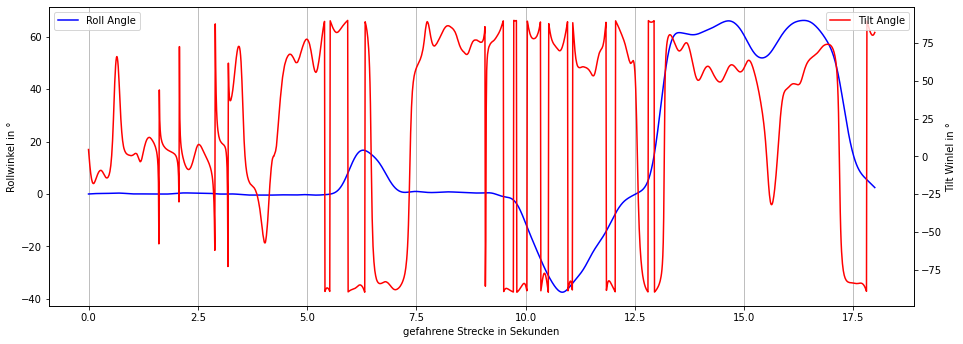

In [211]:
fig, ax1 = plt.subplots(figsize=(15.5, 5.5))

ax2 = ax1.twinx()

ax1.plot(df['time_s'],df["_roll_angle_°"],'blue', label='Roll Angle')

ax2.plot(df['time_s'],df["tilt_value"],"red", label='Tilt Angle')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
#fig, ax1 = plt.title('My title')
ax1.set_xlabel('gefahrene Strecke in Sekunden')
ax1.set_ylabel('Rollwinkel in °')
ax2.set_ylabel('Tilt Winlel in °')
ax1.grid( axis='x')
plt.show()



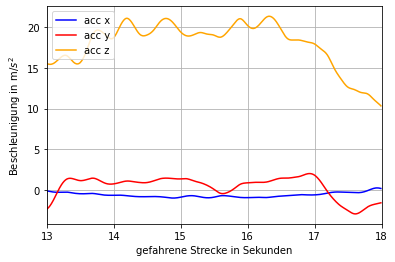

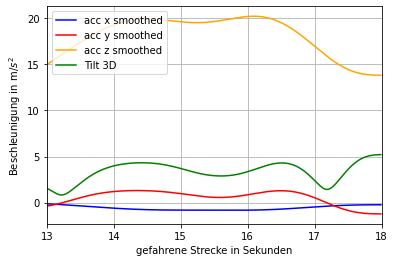

In [208]:

#plt.figure(figsize=(15.5, 5.5))
plt.figure(figsize=(6, 4))
plt.plot(df['time_s'],df["_acc_x_m/s2"],'blue', label='acc x')
plt.plot(df['time_s'],df["_acc_y_m/s2"],'red', label='acc y')
plt.plot(df['time_s'],df["_acc_z_m/s2"],'orange', label='acc z')
plt.legend(loc='upper left')
plt.xlabel('gefahrene Strecke in Sekunden')
plt.ylabel('Beschleunigung in m/$s^2$')
plt.grid()

# Bereich Zoomen
plt.xlim(13, 18)

plt.show()
#plt.figure(figsize=(15.5, 5.5))
plt.figure(figsize=(6, 4))
plt.plot(df['time_s'],df["acc_x_smooth"],'blue', label='acc x smoothed')
plt.plot(df['time_s'],df["acc_y_smooth"],'red', label='acc y smoothed')
plt.plot(df['time_s'],df["acc_z_smooth"],'orange', label='acc z smoothed')

plt.plot(df['time_s'],df["tilt_smooth_3d"],'green', label='Tilt 3D')
plt.legend(loc='upper left')
plt.xlabel('gefahrene Strecke in Sekunden')
plt.ylabel('Beschleunigung in m/$s^2$')
plt.grid()

# Bereich Zoomen
plt.xlim(13, 18)

plt.show()





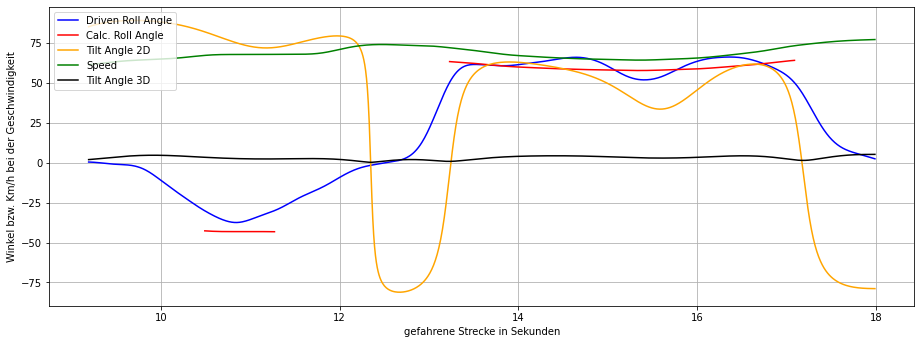

In [220]:
#tiltsmooth = scipy.signal.savgol_filter(df["tilt_value"], 99, 2, mode='nearest')
plt.figure(figsize=(15.5, 5.5))
plt.plot(df['time_s'],df['_roll_angle_°'],'blue', label='Driven Roll Angle') 
plt.plot(df['time_s'],df['opt_calc_angle'],'red', label='Calc. Roll Angle')
plt.plot(df['time_s'],df['tilt_smooth_2d'],'orange', label='Tilt Angle 2D')
plt.plot(df['time_s'],df['_speed_km/h'],'green', label='Speed')
plt.plot(df['time_s'],df["tilt_smooth_3d"],'black', label='Tilt Angle 3D')
#plt.plot(df['time_s'],df['tilt_smooth'],'blue',df['time_s'],df['_roll_angle_°'],'red',df['time_s'],df['acc_z_smooth'],'orange' )
plt.legend(loc='upper left')
plt.xlabel('gefahrene Strecke in Sekunden')
plt.ylabel('Winkel bzw. Km/h bei der Geschwindigkeit')
plt.grid()
plt.show()

https://raw.githubusercontent.com/DFRobot/DFRobotMediaWikiImage/master/Image/_Tilt_angle.png



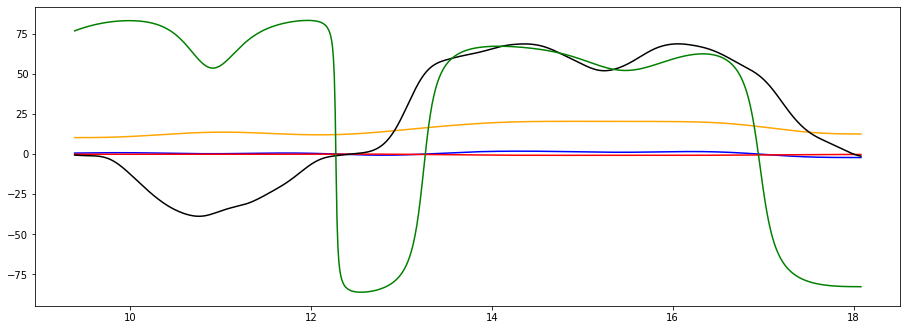

In [151]:
# https://itectec.com/electrical/electrical-how-to-choose-a-cut-off-frequency-by-interpreting-fft/
# https://www.engineeringtoolbox.com/banked-turn-d_1844.html
# https://www.bigrentz.com/blog/superelevation

plt.figure(figsize=(15.5, 5.5))
#plt.plot(rawdatax,'r-')
plt.plot(df['time_s'],df['acc_y_smooth'],'b-')
plt.plot(df['time_s'],df['acc_x_smooth'],'r-')
plt.plot(df['time_s'],df['acc_z_smooth'],'orange')
plt.plot(df['time_s'], df["_roll_angle_°"], "black")
plt.plot(df['time_s'], df['tilt_smooth'], "green")
plt.show()

<Figure size 2160x7344 with 0 Axes>

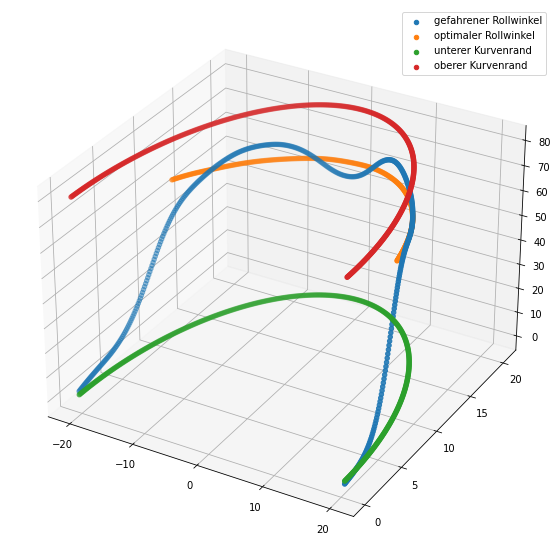

In [92]:
N=50
x_grid = np.linspace(-20, 20, N)
y_grid = np.linspace(-20, 20, N)



fig = plt.figure()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

z = df['_roll_angle_°']
x = 20.5 * np.cos(np.radians(df['curve_angle']))
y = 20.5 * np.sin(np.radians(df['curve_angle']))

z_line = df['opt_rangle']
z_bot = 1
z_top= 80

ax.scatter3D(x, y, z, lw=1,label='gefahrener Rollwinkel')
ax.scatter3D(x, y, z_line, lw=1, label='optimaler Rollwinkel')
ax.scatter3D(x, y, z_bot, lw=1,label='unterer Kurvenrand')
ax.scatter3D(x, y, z_top, lw=1, label='oberer Kurvenrand')
ax.legend()

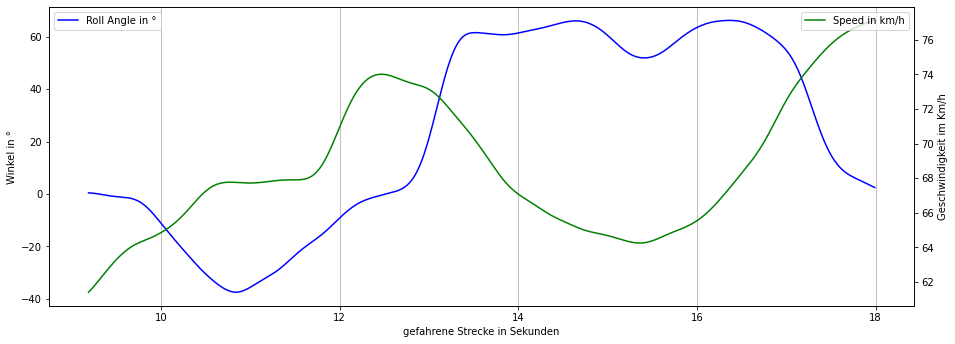

In [155]:
fig, ax1 = plt.subplots(figsize=(15.5, 5.5))
ax2 = ax1.twinx()

ax1.plot(df['time_s'],df["_roll_angle_°"],'blue', label='Roll Angle in °')
#ax1.plot(df['time_s'],df["opt_rangle"],'orange')
#ax1.plot(df['time_s'],df["tilt_smooth"],'grey' )
#ax1.plot(df['time_s'],df["_roll_angle_°"],'blue',df['time_s'],df["acc_z_smooth"],'orange' )
ax2.plot(df['time_s'],df["_speed_km/h"],"green", label='Speed in km/h')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
#fig, ax1 = plt.title('My title')
ax1.set_xlabel('gefahrene Strecke in Sekunden')
ax1.set_ylabel('Winkel in °')
ax2.set_ylabel('Geschwindigkeit im Km/h')
ax1.grid( axis='x')
plt.show()
